In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [2]:
# Download Assignment3.py
!wget https://raw.githubusercontent.com/jdasam/aat3020/main/NLP_Assignment_3.py

--2024-05-10 08:41:14--  https://raw.githubusercontent.com/jdasam/aat3020/main/NLP_Assignment_3.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5473 (5.3K) [text/plain]
Saving to: ‘NLP_Assignment_3.py’

NLP_Assignment_3.py 100%[===================>]   5.34K  --.-KB/s    in 0s      

2024-05-10 08:41:14 (81.0 MB/s) - ‘NLP_Assignment_3.py’ saved [5473/5473]



In [3]:
class MyLSTM(nn.Module):
  def __init__(self, input_size: int, hidden_size: int):
    super().__init__()

    # Define Weights and Bias of a single-layer, uni-directional LSTM
    self.weight_ih = nn.Linear(in_features=input_size, out_features=hidden_size * 4, bias=True)
    self.weight_hh = nn.Linear(in_features=hidden_size, out_features=hidden_size * 4, bias=True)
    self.hidden_size = hidden_size

  def _cal_single_step(self, x_t:torch.Tensor, last_hidden:torch.Tensor, last_cell:torch.Tensor):
    # Gates processing
    gates = self.weight_ih(x_t) + self.weight_hh(last_hidden)
    i, f, g, o = gates.chunk(4, 1)

    # Input, forget, and output gates
    i = torch.sigmoid(i)
    f = torch.sigmoid(f)
    g = torch.tanh(g)
    o = torch.sigmoid(o)

    # Update the cell state
    updated_cell = f * last_cell + i * g

    # Update the hidden state
    updated_hidden = o * torch.tanh(updated_cell)

    return updated_hidden, updated_cell

  def forward(self, x:torch.Tensor, hidden_and_cell_state:tuple=None):
    # Initialize hidden and cell states if not provided
    if hidden_and_cell_state is None:
      last_hidden = torch.zeros([x.shape[0], self.hidden_size], device=x.device)
      last_cell = torch.zeros([x.shape[0], self.hidden_size], device=x.device)
    else:
      last_hidden, last_cell = hidden_and_cell_state

    outputs = []

    # Process each time step
    for t in range(x.shape[1]):
      x_t = x[:, t, :]
      last_hidden, last_cell = self._cal_single_step(x_t, last_hidden, last_cell)
      outputs.append(last_hidden.unsqueeze(1))

    # Concatenate all hidden states
    output = torch.cat(outputs, dim=1)

    return output, (last_hidden, last_cell)


In [4]:
'''
Simple test case
'''

input_size = 16
hidden_size = 32

model = MyLSTM(input_size, hidden_size)

dummy_batch_size = 8
dummy_time_steps = 20
dummy_input = torch.randn([dummy_batch_size, dummy_time_steps, input_size])

output, (last_hidden_state, last_cell_state) = model(dummy_input)

assert output.shape[0] == dummy_batch_size, "0th dimension of output has to be the batch size"
assert output.shape[1] == dummy_time_steps, "1st dimension of output has to be the time steps"
assert output.shape[2] == hidden_size, "2nd dimension of output has to be the hidden_size"



In [5]:
'''
Your LSTM model has to return same output for the script below
'''

# Without for loop
total_output, (last_hidden_state, last_cell_state) = model(dummy_input)

hidden_and_cell_state = (torch.zeros([dummy_batch_size, hidden_size]), torch.zeros([dummy_batch_size, hidden_size]))
for i in range(dummy_time_steps):
  time_step_output, hidden_and_cell_state = model(dummy_input[:,i:i+1], hidden_and_cell_state)

assert (total_output[:,-1:] == time_step_output).all(), 'The LSTM output has to be equal for sliced input using for-loop'

In [6]:
'''
The script below tests whether your implementation returns same output with PyTorch's official LSTM implementation

To pass this test, you have to make sure that you are using the weight of `self.weight_hh` and `self.weight_ih` as the same order
with the official PyTorch LSTM

Be careful on the order of W_i, W_f, W_c, W_o in the combined weight matrix, when you declare your LSTM's forward propagation!

self.weight_ih (nn.Linear): Linear layer that combines Weight matrix [W_i | W_f | W_c | W_o] and bias b
self.weight_hh (nn.Linear): Linear layer that combines Weight matrix [U_i | U_f | U_c | U_o] and bias b
'''


lstm_pre_impl = nn.LSTM(input_size, hidden_size, batch_first=True)

lstm_pre_impl.weight_hh_l0.data = model.weight_hh.weight.data
lstm_pre_impl.bias_hh_l0.data = model.weight_hh.bias.data

lstm_pre_impl.weight_ih_l0.data = model.weight_ih.weight.data
lstm_pre_impl.bias_ih_l0.data = model.weight_ih.bias.data


output, (last_hidden_state, last_cell_state) = model(dummy_input)
output_compare, (last_hidden_state_compare, last_cell_state_compare) = lstm_pre_impl(dummy_input)

assert torch.allclose(output, output_compare, atol=1e-6), "The output of LSTM is different"
assert torch.allclose(last_hidden_state, last_hidden_state_compare, atol=1e-6), "The last hidden state of LSTM is different"
assert torch.allclose(last_cell_state, last_cell_state_compare, atol=1e-6), "The last cell state of LSTM is different"

print("Test passed! Your LSTM implementation returns the exactly same result for PyTorch's official implementation of single-layer uni-directiona LSTM")

Test passed! Your LSTM implementation returns the exactly same result for PyTorch's official implementation of single-layer uni-directiona LSTM


In [2]:
!python3 NLP_Assignment_3_20201036.py

Test passed! Your LSTM implementation returns the exactly same result for PyTorch's official implementation of single-layer uni-directiona LSTM


In [3]:
assert torch.cuda.is_available(), "This assignment is recommended to be run on GPU"

!pip install transformers==4.38.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 67.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.2
    Uninstalling transformers-4.40.2:
      Successfully uninstalled transformers-4.40.2


In [4]:
'''
This will take some minutes to download the model
'''

from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModelForCausalLM.from_pretrained("distilgpt2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [6]:
def read_txt(txt_path):
    encodings = ['utf-8', 'ISO-8859-1', 'cp1252', 'latin1']
    for encoding in encodings:
        try:
            with open(txt_path, 'r', encoding=encoding) as f:
                return f.readlines()
        except UnicodeDecodeError:
            continue
    raise ValueError(f"All encodings failed for file {txt_path}")


class TextSet:
  def __init__(self, txt_path, tokenizer, batch_len=256):
    corpus_string = read_txt(txt_path)
    self.text_in_a_string = "".join(corpus_string).replace('\n', ' ')

    self.tokenizer = tokenizer
    self.tokenized_corpus = self.tokenizer(self.text_in_a_string,max_length=2000000)['input_ids']
    self.batch_len = batch_len

    self.tokenized_corpus = self.tokenized_corpus[:len(self.tokenized_corpus)//self.batch_len*self.batch_len]
    self.corpus_tensor = self._batchify_text()

  def _batchify_text(self):
    entire_corpus_tensor = torch.LongTensor(self.tokenized_corpus)
    return entire_corpus_tensor.reshape(-1, self.batch_len)

  def __len__(self):
    return len(self.corpus_tensor)

  def __getitem__(self, idx):
    return self.corpus_tensor[idx]

'''
TODO: select your own txt path
'''

your_txt_path = "/content/final_al_jazeera_articles-2.txt" # select your own txt path
train_set = TextSet(your_txt_path, tokenizer, batch_len=256)

# The code below will show how the tokenizer convert and reconvert the given text
train_set[0], train_set.tokenizer.decode(train_set[0])

(tensor([35969,  8406,   329,  4725,  9931,   900,   329,  4765,  4281,  3015,
           553,    32,  1578,  7973,  6323, 21787,   262, 22890,  1812,   286,
         17263,  1336,  9931,   379,   262,  3230,  1767,   561,   307,   281,
           564,   250, 18049, 30042,   287, 16937,  4167,   287,   262,  3814,
           447,   251,    11, 45643,   324, 13098,  1703,    81,    11,  4725,
          2041,  8852,   286,   262, 22890,  1812,   286, 17263,    11,   468,
          1297,   262,  4725,  4765,  4281,   357,  4944,  6173,     8,  4058,
           286,   257,  3015,    13,   564,   250,  1135,   389,   991, 40314,
           284,  3357,   674,   826,   284,  2116,    12, 40869,    11,   284,
          2107,   287,  4925,    11,  2324,   290,  4167,   287,   281,  4795,
          1181,  2092,   284,   584,  2678,  1088,   262,   995,    11,   447,
           251, 13098,  1703,    81,   531,   319,  3635,    11,  4375,   326,
         12890,   564,   250,  9727,   290,  2555,  

In [7]:
'''
define train_loader
'''

from torch.utils.data import DataLoader
train_set = TextSet(your_txt_path, tokenizer, batch_len=256)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)


- In your report, briefly explain how this code trains a language model

100%|██████████| 500/500 [12:00<00:00,  1.44s/it]


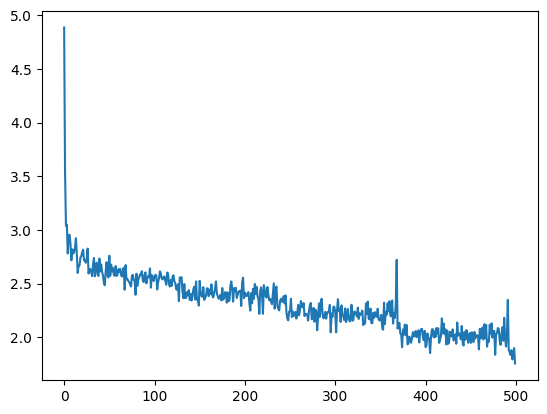

In [22]:
from tqdm import tqdm


'''
Use CUDA (NVIDIA GPU) to train your model
'''

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_record = []
model.cuda()
num_iteration = 500 # you can change num updates here

train_iter = iter(train_loader)

for i in tqdm(range(num_iteration)):
  try:
    batch = next(train_iter)
  except StopIteration:
    train_iter = iter(train_loader)
    batch = next(train_iter)
  out = model(batch.cuda()).logits
  out = torch.log_softmax(out, dim=-1)
  correct_next_word = batch[:, 1:]
  out_flatten = out[:, :-1, :].reshape(-1, out.shape[-1])
  correct_next_word = correct_next_word.reshape(-1)

  log_prob_of_correct_word = out_flatten[torch.arange(len(correct_next_word)), correct_next_word]

  loss = -log_prob_of_correct_word.mean()
  loss.backward()

  optimizer.step()
  optimizer.zero_grad()
  loss_record.append(loss.item())

plt.plot(loss_record)

### Problem 2-2: Generate Text with your fine-tuned Model
- Here, you have to generate text with the fine-tuned model
- You have to provide interesting prompt, that is given as a precedding sequence of token
- In your report, introduce interesting examples you have generated
    - Why those were interesting


In [23]:
'''
Declare generator using HuggingFace library
'''
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=0)

del out, batch

In [25]:
your_prompt = "When summerize about Israel Palestine war" # caution: Do not add blank space at the end of the prompt
your_max_length = 100
your_num_sequences = 5

generator(your_prompt, max_length=your_max_length, num_return_sequences=your_num_sequences)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'When summerize about Israel Palestine war, there was a lot of talk that the Biden administration was going to use the cold war to try and avoid a major escalation in the war.?Not to mention the very real danger of an escalation that could turn into war. The only way to end what has long been one of the most brutal military campaigns of our era to end the war is through a comprehensive but comprehensive international agreement with Israel. The United States has made no secret of its continuing opposition to Israel�'},
 {'generated_text': 'When summerize about Israel Palestine war, it’s hard to deny it’s a political issue altogether, but it does seem to be shifting so drastically and disproportionately in the US. US President Joe Biden used a weekend speech last week to criticise Netanyahu over the weekend following the release of 17 captives taken by Palestinian journalists. Speaking in the US capital, St. Louis, Biden had described Netanyahu and his efforts to brin

In [27]:
your_prompt = "My opinion about Israel Palestine war is" # caution: Do not add blank space at the end of the prompt
your_max_length = 100
your_num_sequences = 5

generator(your_prompt, max_length=your_max_length, num_return_sequences=your_num_sequences)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'My opinion about Israel Palestine war is very bad. This conflict is going on for generations, which is why we launched the International Organization for Migration (IoMTO) to save Palestine for the present era.” WCK says it will be donating humanitarian relief supplies via a voluntary donor if Israel invades Rafah and releases the remaining captives. “We are looking at ways in which we can provide assistance that can alleviate some of the greatest suffering, whether internally displaced persons or in war-'},
 {'generated_text': 'My opinion about Israel Palestine war is not good. Palestine and Palestine are not unique places. They have lost the last thousand years of civilisation and civilisation and civilisation are gone forever,” Eilat told Al Jazeera.",,,, ‘Biden vows farewell to US, British and Israeli leaders to send a message to Israel’s critics’: Netanyahu speaks to a press conference,"US President Joe Biden has said his country has been a miscalculation and 

In [28]:
'''
Generate sentences using your own prompt and your max legnth

'''

your_prompt = "Sogang Yonsei war is" # caution: Do not add blank space at the end of the prompt
your_max_length = 100
your_num_sequences = 5

generator(your_prompt, max_length=your_max_length, num_return_sequences=your_num_sequences)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Sogang Yonsei war is the “latest major escalation since October 7, which saw the Palestinian people take a major blow against the Zionist entity], and the escalation we are seeing is continuing as we wait for its cessation as well in Jordan and Egypt, and the West Bank and Gaza,” the analyst said.    ",,,, Are Israel’s war on Gaza likely to last longer?,"Deir al-Balah, Gaza? In early December, the Palestinian'},
 {'generated_text': 'Sogang Yonsei war is not at the margin of war for Netanyahu. But it is not stopping Gaza from deteriorating into a famine. Against that backdrop, Israeli Prime Minister Benjamin Netanyahu is appealing in the hope that an agreement is reached between Netanyahu and Hamas in exchange for the release of all Israeli captives. While there is no immediate date for when the swap would be done, Israel is under pressure now to fulfil its key objectives of crushing Hamas and freeing prisoners in Gaza. “It is a'},
 {'generated_text': 'Sogang Yonsei

In [29]:
'''
Generate sentences using your own prompt and your max legnth

'''

your_prompt = "Difference between Korean war and Israel Palestine war" # caution: Do not add blank space at the end of the prompt
your_max_length = 100
your_num_sequences = 5

generator(your_prompt, max_length=your_max_length, num_return_sequences=your_num_sequences)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Difference between Korean war and Israel Palestine war, and that of its own member state was not the case, and there was a very strong bias involved in determining? what was to be expected? the number of projectiles fired and the number of people arrested along with whether the United States considered it a sufficient impediment to normalising ties between the two countries. When the projectile was fired, it exited the occupied West Bank. On the contrary, the projectile continued to rain down on Palestinian lands, creating severe'},
 {'generated_text': 'Difference between Korean war and Israel Palestine war, it is difficult to know the reasons behind those positions. The US was aware of the plight of the Palestinian people as it prepared to invade the territory. South Korea has a history of placing humanitarian aid on the shoulders of Palestinians, though it does not consider South Korea a serious threat. The ruling Workers’ Party in the Workers’ Party of Korea str